In [ ]:
import intake
from easygems import healpix as egh
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

from scipy.stats import skew

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Time period

time = ('2020-04-01','2020-04-30')

# Region

domains10x10 = {
    "peruvian":     np.array([-90, -80, -20, -10]) ,
    "namibian":     np.array([0, 10, -20, -10]),
    "californian":  np.array([-130, -120, 20, 30]),
    "canarian":     np.array([-35, -25, 15, 25])
}

map_domain = domains10x10['namibian']

In [ ]:
# Load datasets

hknode = 'EU'

cat = intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")[hknode]
print(list(cat))

ds_ifs = cat['ifs_tco3999-ng5_rcbmf_cf'](time='PT1H',zoom=11).to_dask().pipe(egh.attach_coords)
ds_icon = cat['icon_d3hp003'](time_method='inst',time='PT6H',zoom=11).to_dask().pipe(egh.attach_coords)
ds_nicam = cat['nicam_gl11'](time='PT3H',zoom=9).to_dask().pipe(egh.attach_coords)
ds_um = cat['um_glm_n2560_RAL3p3'](time='PT1H',zoom=10).to_dask().pipe(egh.attach_coords)

In [4]:
# Select time period and and region

cells_ifs = egh.isel_extent(ds_ifs,map_domain)
cells_icon = egh.isel_extent(ds_icon,map_domain)
cells_nicam = egh.isel_extent(ds_nicam,map_domain)
cells_um = egh.isel_extent(ds_um,map_domain)

ds_ifs = ds_ifs.sel(time=slice(*time)).isel(cell=cells_ifs)
ds_icon = ds_icon.sel(time=slice(*time)).isel(cell=cells_icon)
ds_nicam = ds_nicam.sel(time=slice(*time)).isel(cell=cells_nicam)
ds_um = ds_um.sel(time=slice(*time)).isel(cell=cells_um)

ds_icon['qallvi'] = (ds_icon['qall'].integrate('pressure')/9.81) \
    .assign_attrs(long_name='Total condensate', units='kg/m^2')

var_ifs = 'clwvi'
var_icon = 'qallvi'
var_nicam = 'clwvi'
var_um = 'clwvi'

In [ ]:
%%time

# Distribution parameters

skewness_list, mean_list, std_list, mean_div_by_std  = {}, {}, {}, {}

for (ds, var, name) in [(ds_icon, var_icon, 'icon'), (ds_ifs, var_ifs, 'ifs'), (ds_nicam, var_nicam, 'nicam'), (ds_um, var_um, 'um')]:
    print(name)

    skewness_list[name] = []
    mean_list[name] = []
    std_list[name] = []
    mean_div_by_std[name] = []
    
    time_step = np.timedelta64(1,'D') # every 1 day
    time_list = np.arange(ds.time[0].values,ds.time[-1].values,time_step)
    
    for t in time_list:
        data = ds[var].sel(time=t)

        skewness_list[name].append(skew(data))
        mean_list[name].append(np.mean(data))
        std_list[name].append(np.std(data))
                
    mean_div_by_std[name] = (np.array(mean_list[name]) / np.array(std_list[name]))**2

ifs
icon
nicam
um


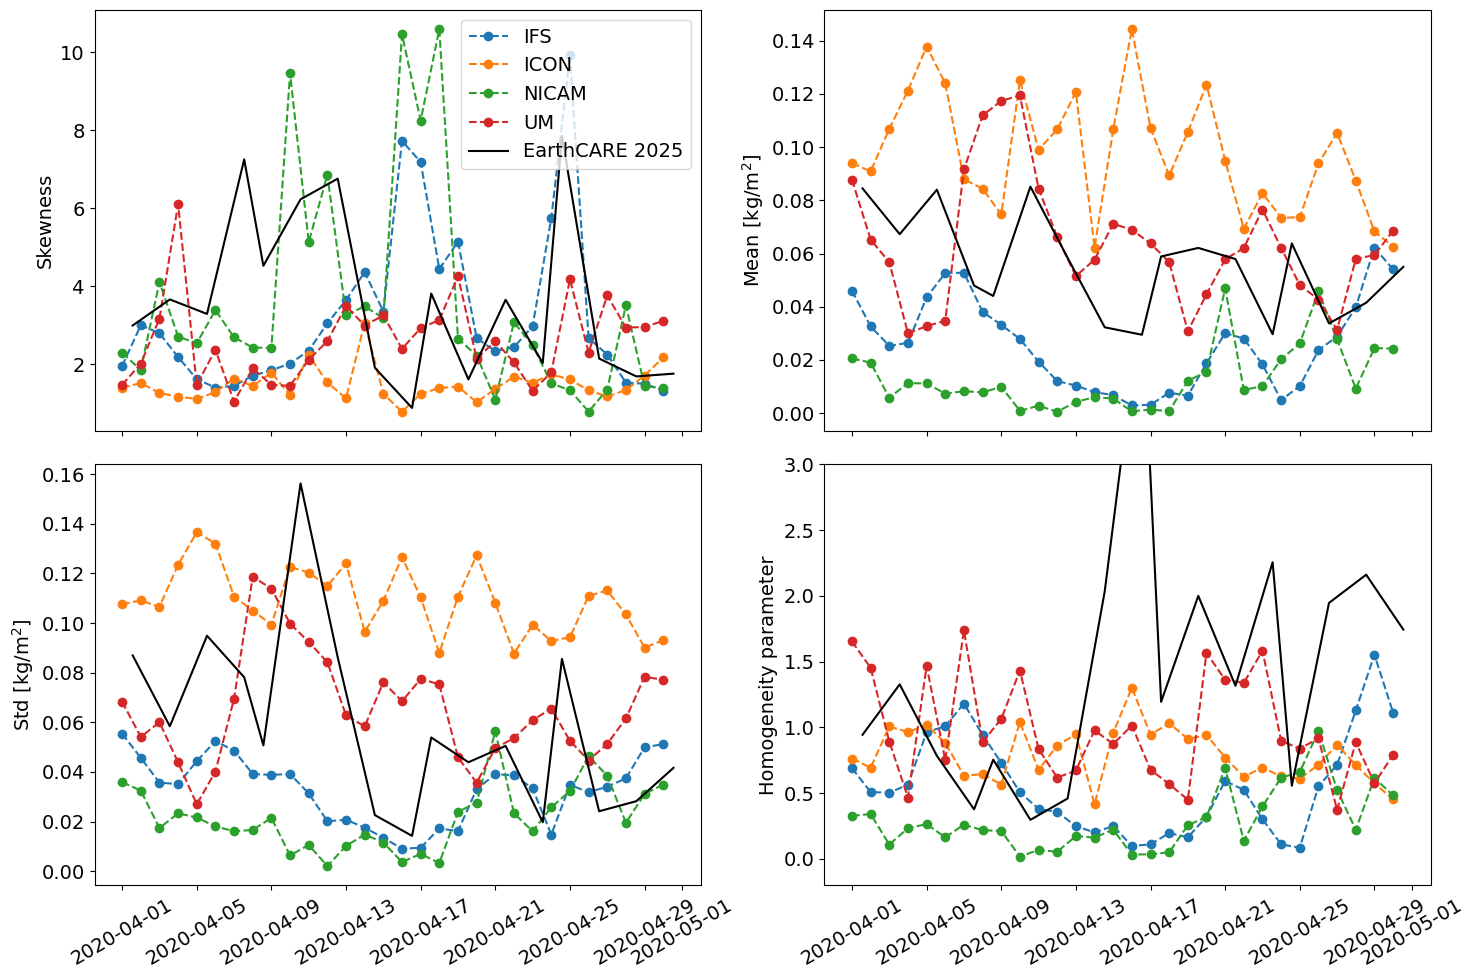

In [64]:
fig, ax = plt.subplots(2,2, figsize = (15,10), sharex=True)
plt.style.use('default')
plt.rcParams['font.size'] = 14

for name in ['ifs', 'icon', 'nicam', 'um']:
    print(name)
    ax[0][0].plot(time_list, skewness_list[name], marker = 'o', linestyle = '--')
    ax[0][1].plot(time_list, mean_list[name], marker = 'o', linestyle = '--')
    ax[1][0].plot(time_list, std_list[name], marker = 'o', linestyle = '--')
    ax[1][1].plot(time_list, mean_div_by_std[name], marker = 'o', linestyle = '--')

df = pd.read_csv('~/stcu_morphology.csv')
df['date_time'] = pd.to_datetime(df['date_time'], format='%Y%m%dT%H%M%SZ')
df = df.sort_values(by='date_time', ascending=True)
df['date_time'] = df['date_time'].apply(lambda dt: dt.replace(year=2020))

ax[0][0].plot(df['date_time'], df['lwp_skew'], color='black')
ax[0][1].plot(df['date_time'], df['lwp_mean'], color='black')
ax[1][0].plot(df['date_time'], df['lwp_std'], color='black')
ax[1][1].plot(df['date_time'], df['homog_param'], color='black')

ax[0][0].set_ylabel('Skewness')
ax[0][1].set_ylabel('Mean [kg/m$^2$]')
ax[1][0].set_ylabel('Std [kg/m$^2$]')
ax[1][1].set_ylabel('Homogeneity parameter')
ax[1][1].set_ylim(-0.2, 3)

for row in ax:
    for axis in row:
        axis.tick_params("x", rotation=30)
ax[0][0].legend(['IFS', 'ICON', 'NICAM', 'UM', 'EarthCARE 2025'])
plt.tight_layout()
plt.savefig('outputs/statistics',bbox_inches='tight',dpi=300)
plt.show()
#plt.close(fig)